In [1]:
#This program loads data from 4 different classes
#good, bad, human, maybe
#And uses 10 different acoustic indices on num_spec recordings from each
#Each recording is exactly 2 s long
#Final result: a scatter plot for each acoustic index
#Values on x axis: values of acoustic index
#Colours: for each class
#List of acoustic indices used: 
#1. ACI 2. Roughness 3. Temporal entropy 4. Acoustic diversity 5. Acoustic richness 
#6. Spectral diversity 7. Spectral kurtosis 8. Spectral entropy 9. ?? 10. ??

#imports
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import hilbert
from scipy.signal import stft
import librosa
import os

#for scatter matrix
import pandas as pd
from pandas.plotting import scatter_matrix

#setting eps value for converting spec to log
eps = 1e-10

#function definitions for acoustic indices begin here


In [2]:
#1. ACI
def compute_aci(specs, time_steps, freq_bins):
      
    #Function computes Acoustic Complexity Index
    #According to:
    #http://www.iinsteco.org/people/pubblications/almo/2011/2011_A_new%20methodology_to_infer_the_singing_activity.pdf

      
    abs_diff = np.abs(specs[:, :, 1:] - specs[:, :, 0:time_steps-1])
    ACI = np.sum(np.sum(abs_diff, axis = 2)/np.sum(specs, axis = 2), axis = 1)
       
    return ACI

In [3]:
#2. Acoustic diversity
def compute_adi(specs, time_steps):

    #Function computes Acoustic Diversity Index
    #According to:
    #Pekin (2012)
    #except 70 frequency points have been grouped into 7 bins 
    
    ADI_bins = np.zeros((7,1))
    ADI_bins_norm = np.zeros((7,1))
    
    ADI_all = 0
    
    for i in range(7):      
        
        #for loop for all time steps in same freq bin - sum each row
        start = i
        stop = i+10
        
        ADI_bins[i] = np.sum(specs[start:stop, :])
        #print(ADI_bins[i])
       
        
    #normalization
    ADI_bins_norm = ADI_bins/np.sum(ADI_bins)
    #print(ADI_bins_norm)
    ADI_all = np.sum( ADI_bins_norm * np.log(ADI_bins_norm))
    #print(ADI_all)
   
    return ADI_all


In [4]:
#Helper function for compute_adi_even
def get_start_stop_indices(freq_bins, multiples=1000, num_bins=8):
    
    #find the frequency index numbers to group in bins of 1kHz width from 0-1 kHz, 1-2, till 7-8kHz
    stop_freq_idx = np.zeros((num_bins, 1))
    start_freq_idx = np.zeros((num_bins,1))

    for i in range(num_bins):
        stop_freq = multiples*(i+1)
        #to find the index to clip
        stop_freq_idx[i] = freq_bins.searchsorted(stop_freq, side='right') - 1
        if (i<num_bins-1):
            start_freq_idx[i+1] = stop_freq_idx[i]+1
        
    return start_freq_idx, stop_freq_idx
        
    
#3. Acoustic diversity with evenly spaced bins
def compute_adi_even(specs, freq_vals, start_indices, stop_indices):

    #Function computes Acoustic Diversity Index
    #According to:
    #Pekin (2012)
  
    '''To see the frequency values - verified
    print("Start vals: ")
    for i in range(num_bins):
        start = int(start_indices[i])
        print(freq_vals[start])
     
    print("Stop vals: ")
    for i in range(num_bins):
        stop = int(stop_indices[i])
        print(freq_vals[stop])'''
               
    ADI_bins = np.zeros((num_bins, 1))
    ADI_bins_norm = np.zeros((num_bins,1))
    
    ADI_all = 0
    
    for i in range(num_bins):      
    
        #for loop for all time steps in same freq bin - sum each row
        start = int(start_indices[i])
        stop = int(stop_indices[i])
        ADI_bins[i] = np.sum(specs[start:stop, :])
        #print(ADI_bins[i])
       
        
    #normalization
    ADI_bins_norm = ADI_bins/np.sum(ADI_bins)
    #print(ADI_bins_norm)
    ADI_all = np.sum( ADI_bins_norm * np.log(ADI_bins_norm))
    #print(ADI_all)
   
    return ADI_all

In [5]:
#4. Spectral entropy 
def compute_sh(spec, time_steps, freq_bin):
    
    #This function is a modified version of  spectral entropy as described in Sueur (2008)

       
    spec_norm = np.zeros((freq_bin, 1))
    sh = np.zeros((time_steps, 1))

    
    #normalizing and getting sh
    for i in range(time_steps):
        spec_norm = np.abs(spec[:, i])/np.sum(np.abs(spec[:, i]))
        '''if (i==0):
            print(spec_norm)'''
        sh[i] = - np.sum(np.multiply(spec_norm, np.log2(spec_norm + eps)))
      
    sh = sh/np.log2(freq_bin)
    
    sh_all = np.sum(sh)/freq_bin
    #to keep it between 0 and 1   
    
    return sh_all

In [6]:
def compute_ndsi(spec, start_indices, stop_indices, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq):
    
    #Taken from the Kasten 2012 paper - page 6 has NDSI description
    
    #Anthrophony bin: 1-2 kHz
    start_a = int(start_indices[start_a_freq])
    stop_a = int(stop_indices[stop_a_freq-1])
    
    #Biophony bin: 2-8 kHz
    start_b = int(start_indices[start_b_freq])
    stop_b = int(stop_indices[stop_b_freq-1])
    
    #Taking absolute value - power spectral density was squared, so intensities are made positive here
    
    #anth_sum = np.sum(np.abs(spec[start_a:stop_a, :]))
    #bio_sum = np.sum(np.abs(spec[start_b:stop_b, :]))
    #NDSI = (bio_sum-anth_sum)/(bio_sum+anth_sum)
    
    anth_sum = np.sum(np.sum(np.abs(spec[:, start_a:stop_a, :]), axis = 2), axis = 1)
    bio_sum = np.sum(np.sum(np.abs(spec[:, start_b:stop_b, :]), axis = 2), axis = 1)
    NDSI = (bio_sum-anth_sum)/(bio_sum+anth_sum)
    
    return NDSI

In [7]:
#function to load spectrograms and display dimensions (optional)
def load_display_dimensions(class_name, dim=0):

    #   description of data files
    #   spec_data is like a dict with fields
    #   'specs' (contains the mel-filtered spectrograms, in linear scale, as [num_specs, num_rows, num_cols])
    #   'spec_f' (contains the frequency axis points as a 1D array)
    #   'spec_t' (contains the time axis points as a 1D array)   
    
    fname_load = class_name + '.npz'
    spec_data = np.load(fname_load)
    
    time_steps = len(spec_data['spec_t'])
    freq_bins = len(spec_data['spec_f'])
    
    if (dim==1):
        print('File has %i specs of dimensions (%i x %i)' % (
        spec_data['specs'].shape[0], spec_data['specs'].shape[1], spec_data['specs'].shape[2]))
        print('Frequency axis points are in spec_data[\'spec_f\'] and has %i values' % freq_bins)
        print('Time axis points are in spec_data[\'spec_t\'] and has %i values' % time_steps)
        
    return spec_data, time_steps, freq_bins
    


In [8]:
#function to calculate all acoustic indices and plot spectrogram (optional)
def calc_plot(spec_start_idx, num_specs, spec_data, time_steps, freq_bins, freq_vals, start_freq_idx, stop_freq_idx, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot=0):

    ACI = np.zeros((num_specs, 1))
    ADI = np.zeros((num_specs, 1))
    ADI_even = np.zeros((num_specs, 1))
    SH = np.zeros((num_specs, 1))
    NDSI = np.zeros((num_specs, 1))
    #2. Roughness 3. Temporal entropy 4. Acoustic diversity 5. Acoustic richness 
    #6. Spectral diversity 7. Spectral kurtosis 8. Spectral entropy 9. ?? 10. ??
    
    if (plot==1):
        fig, axes = plt.subplots(num_specs, 1, sharex='all')
        plt.title('Spectrogram for ' + 'good')
      
    #Calculation of acoustic indices for num_spec spectrograms here
    all_specs = 10 * np.log10(spec_data['specs'][spec_start_idx:spec_start_idx+num_specs, :, :] + eps)
    ACI = compute_aci(all_specs, time_steps, freq_bins)
    #print("ACI value is: ", ACI)  
    NDSI = compute_ndsi(all_specs, start_freq_idx, stop_freq_idx, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq)
      
    for spec_idx in range(num_specs):
        
        
        #Printing frequency points
        '''
        if(spec_idx==0):
            print (spec_data['spec_f'])'''
        #current_spec = 10 * np.log10(spec_data['specs'][spec_start_idx + spec_idx, :, :] + eps)
        
        #Getting current spec from saved log spec
        current_spec = all_specs[spec_start_idx + spec_idx, :, :] 
        
        #Calculation of acoustic indices for num_spec spectrograms here
        #ACI[spec_idx] = compute_aci(current_spec, time_steps, freq_bins)
        #print("ACI value is: ", ACI[spec_idx])
        
        ADI[spec_idx] = compute_adi(current_spec, time_steps)
        #print("ADI value is: ", ADI[spec_idx])
        
        ADI_even[spec_idx] = compute_adi_even(current_spec, freq_vals, start_freq_idx, stop_freq_idx)
        #print("ADI_even value is: ", ADI_even[spec_idx])

        SH[spec_idx] = compute_sh(current_spec, time_steps, freq_bins)
        #print("SH value is: ", SH[spec_idx])
        
        #NDSI[spec_idx] = compute_ndsi(current_spec, start_freq_idx, stop_freq_idx, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq)
        #print("NDSI value is: ", NDSI[spec_idx])
        
        #2. Roughness 3. Temporal entropy 4. Acoustic diversity 5. Acoustic richness 
        #6. Spectral diversity 7. Spectral kurtosis 8. Spectral entropy 9. ?? 10. ??
        
        if(plot==1):
            cax = axes[spec_idx].imshow(current_spec, cmap=plt.get_cmap('jet'), interpolation='none', origin='lower')
            fig.colorbar(cax, ax=axes[spec_idx], orientation='vertical')
        
    
    return ACI, ADI, ADI_even, SH, NDSI
        #2. Roughness 3. Temporal entropy 4. Acoustic diversity 5. Acoustic richness 
        #6. Spectral diversity 7. Spectral kurtosis 8. Spectral entropy 9. ?? 10. ??



In [9]:
def scatter_plot(AI_G, AI_B, AI_H, AI_M, AI_type, num_specs_g, num_specs_b, num_specs_h, num_specs_m):
    
    AI_g = (AI_G, np.ones((num_specs_g, 1)))  
    AI_b = (AI_B, 2*np.ones((num_specs_b, 1)))    
    AI_h = (AI_H, 3*np.ones((num_specs_h, 1)))    
    AI_m = (AI_M, 4*np.ones((num_specs_m, 1)))   
    
    data = (AI_g, AI_b, AI_h, AI_m)
    colors = ("red", "blue", "black", "green")
    groups = ("good", "bad", "human", "maybe") 
     
    # Create plot
    fig_scatter = plt.figure()
    ax = fig_scatter.add_subplot(1, 1, 1, facecolor="1.0")
     
    for data, color, group in zip(data, colors, groups):
        x, y = data
        #print(x.shape, y.shape)
        ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
     
    plt.title('Scatter Plot for ' + AI_type)
    plt.legend(loc=2)        
        

In [10]:
def scatter_plot2(AI_G, AI_B, AI_H, AI_M, AI_type, num_specs_g, num_specs_b, num_specs_h, num_specs_m, AI_G2, AI_B2, AI_H2, AI_M2, AI_type2):
    
    AI_g = (AI_G, AI_G2)  
    AI_b = (AI_B, AI_B2)    
    AI_h = (AI_H, AI_H2)    
    AI_m = (AI_M, AI_M2)   
    
    data = (AI_g, AI_b, AI_h, AI_m)
    colors = ("red", "blue", "black", "green")
    groups = ("good", "bad", "human", "maybe") 
     
    # Create plot
    fig_scatter = plt.figure()
    ax = fig_scatter.add_subplot(1, 1, 1, facecolor="1.0")
     
    for data, color, group in zip(data, colors, groups):
        x, y = data
        #print(x.shape, y.shape)
        ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
     
    plt.title('Scatter Plot for ' + AI_type + ' vs ' + AI_type2)
    plt.legend(loc=2)

In [11]:
#calls all functions for each class
def calls(class_name, spec_start_idx, num_specs, multiples, num_bins, dim, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot=0):

    #Load the correct file
    spec_data, time_steps, freq_bins = load_display_dimensions(class_name, dim)
    
    #Calling helper function for compute_adi_even
    start_freq_idx, stop_freq_idx = get_start_stop_indices(spec_data['spec_f'], multiples, num_bins)

    #Computing acoustic indices
    ACI, ADI, ADI_even, SH, NDSI = calc_plot(spec_start_idx, num_specs, spec_data, time_steps, freq_bins, spec_data['spec_f'], start_freq_idx, stop_freq_idx, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
    #2. Roughness 3. Temporal entropy 4. Acoustic diversity 5. Acoustic richness 
    #6. Spectral diversity 7. Spectral kurtosis 8. Spectral entropy 9. ?? 10. ??
    
    return ACI, ADI, ADI_even, SH, NDSI
    #2. Roughness 3. Temporal entropy 4. Acoustic diversity 5. Acoustic richness 
    #6. Spectral diversity 7. Spectral kurtosis 8. Spectral entropy 9. ?? 10. ??

    

Done with class Good
Done with class Bad
Done with class Human
Done with class Maybe


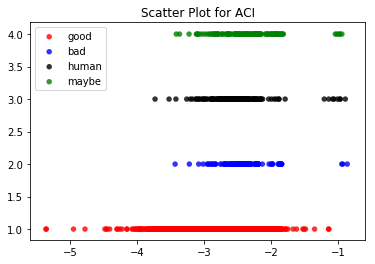

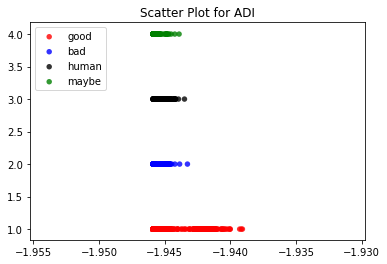

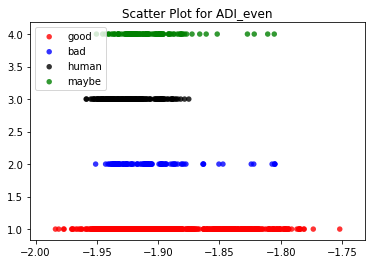

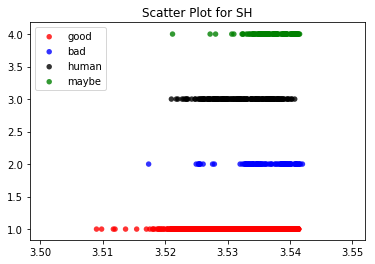

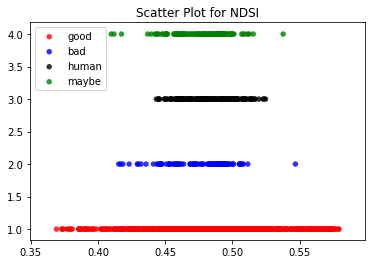

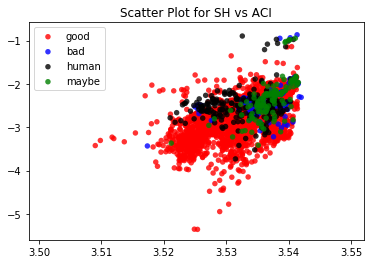

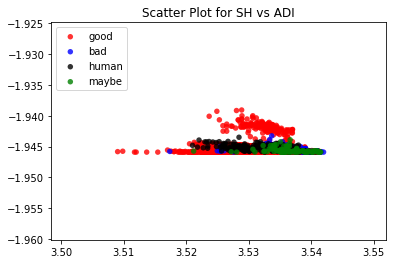

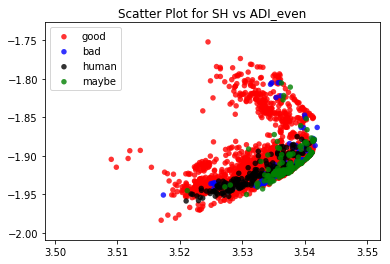

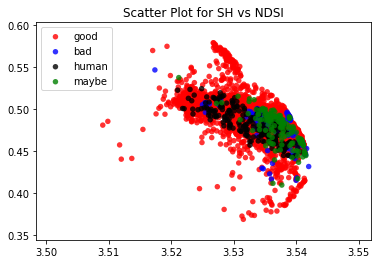

In [12]:
#Main

#Defining classes
class1 = 'good'
class2 = 'bad'
class3 = 'human'
class4 = 'maybe'

#Make sure the indices don't get larger than spec_data['specs'].shape[0]
spec_start_idx = 0
#num_specs = 2


num_specs_g = 2958
num_specs_b = 127
num_specs_h = 205
num_specs_m = 131
'''
num_specs_g = 120
num_specs_b = 120
num_specs_h = 120
num_specs_m = 120'''
#Other parameters
plot = 0
dim = 0
num_bins = 8            #for compute_adi_even
multiples=1000

#NDSI frequencies in kHz
start_a_freq = 1
stop_a_freq = 2
start_b_freq = 2
stop_b_freq = 8

#Calls for each class
ACI_G, ADI_G, ADI_even_G, SH_G, NDSI_G = calls(class1, spec_start_idx, num_specs_g, multiples, num_bins, dim, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
print("Done with class Good")
ACI_B, ADI_B, ADI_even_B, SH_B, NDSI_B = calls(class2, spec_start_idx, num_specs_b, multiples, num_bins, dim, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
print("Done with class Bad")
ACI_H, ADI_H, ADI_even_H, SH_H, NDSI_H = calls(class3, spec_start_idx, num_specs_h, multiples, num_bins, dim, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
print("Done with class Human")
ACI_M, ADI_M, ADI_even_M, SH_M, NDSI_M = calls(class4, spec_start_idx, num_specs_m, multiples, num_bins, dim, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
print("Done with class Maybe")

#Scatter plot function for 1 at a time
scatter_plot(ACI_G, ACI_B, ACI_H, ACI_M, 'ACI', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
scatter_plot(ADI_G, ADI_B, ADI_H, ADI_M, 'ADI', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
scatter_plot(ADI_even_G, ADI_even_B, ADI_even_H, ADI_even_M, 'ADI_even', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
scatter_plot(SH_G, SH_B, SH_H, SH_M, 'SH', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
scatter_plot(NDSI_G, NDSI_B, NDSI_H, NDSI_M, 'NDSI', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
    
#Scatter plot function for 2 at a time
scatter_plot2(SH_G, SH_B, SH_H, SH_M, 'SH', num_specs_g, num_specs_b, num_specs_h, num_specs_m, ACI_G, ACI_B, ACI_H, ACI_M, 'ACI')
scatter_plot2(SH_G, SH_B, SH_H, SH_M, 'SH', num_specs_g, num_specs_b, num_specs_h, num_specs_m, ADI_G, ADI_B, ADI_H, ADI_M, 'ADI')
scatter_plot2(SH_G, SH_B, SH_H, SH_M, 'SH', num_specs_g, num_specs_b, num_specs_h, num_specs_m, ADI_even_G, ADI_even_B, ADI_even_H, ADI_even_M, 'ADI_even')
scatter_plot2(SH_G, SH_B, SH_H, SH_M, 'SH', num_specs_g, num_specs_b, num_specs_h, num_specs_m, NDSI_G, NDSI_B, NDSI_H, NDSI_M, 'NDSI')


#2. Roughness 3. Temporal entropy 4. Acoustic diversity 5. Acoustic richness 
#6. Spectral diversity 7. Spectral kurtosis 8. Spectral entropy 9. ?? 10. ??

#Display    
plt.show()



In [13]:
import seaborn as sns
sns.set(style="ticks")

#df = sns.load_dataset("iris")
#df.head()

In [14]:
#General procedure to get pandas dataframes: 
#(1)reshape the array
#(2) create a dataframe with columns as acoustic indices
#(3) add an extra column with class name
def convert_df(ind1, ind2, ind3, ind4, ind5, num_specs, class_type):
    ind1 = np.reshape(ind1, (num_specs, ))
    ind2 = np.reshape(ind2, (num_specs, ))
    ind3 = np.reshape(ind3, (num_specs, ))
    ind4 = np.reshape(ind4, (num_specs, ))
    ind5 = np.reshape(ind5, (num_specs, ))
    
    Class = class_type

    data = pd.DataFrame({'ACI': ind1, 'ADI': ind2, 'ADI_even': ind3, 'SH': ind4,'NDSI': ind5, 'Class': Class}, columns=['ACI', 'ADI', 'ADI_even', 'SH', 'NDSI', 'Class'])
    print(data.shape)
    data.head()

    return data

In [15]:
data_G = convert_df(ACI_G, ADI_G, ADI_even_G, SH_G, NDSI_G, num_specs_g, 'Good')
data_G.head()

data_B = convert_df(ACI_B, ADI_B, ADI_even_B, SH_B, NDSI_B, num_specs_b, 'Bad')
data_B.head()

data_H = convert_df(ACI_H, ADI_H, ADI_even_H, SH_H, NDSI_H, num_specs_h, 'Human')
data_H.head()

data_M = convert_df(ACI_M, ADI_M, ADI_even_M, SH_M, NDSI_M, num_specs_m, 'Maybe')
data_M.head()


(2958, 6)
(127, 6)
(205, 6)
(131, 6)


,ACI,ADI,ADI_even,SH,NDSI,Class
0,-2.380273,-1.945866,-1.912025,3.538956,0.479175,Maybe
1,-2.322233,-1.945865,-1.926397,3.535989,0.498334,Maybe
2,-2.221922,-1.945851,-1.925884,3.536346,0.499062,Maybe
3,-2.263325,-1.945849,-1.924609,3.536565,0.497103,Maybe
4,-2.245678,-1.945860,-1.921492,3.536874,0.490987,Maybe


In [16]:
all_data_arr = [data_G, data_B, data_H, data_M]
all_data_df = pd.concat(all_data_arr)

print(all_data_df.shape)
all_data_df.head()

(3421, 6)


,ACI,ADI,ADI_even,SH,NDSI,Class
0,-2.140497,-1.945809,-1.925119,3.534064,0.501186,Good
1,-2.548170,-1.945811,-1.929581,3.531940,0.507842,Good
2,-3.035664,-1.945808,-1.912524,3.530267,0.478780,Good
3,-3.155140,-1.945805,-1.912569,3.529985,0.475351,Good
4,-2.402599,-1.945617,-1.927787,3.532227,0.495920,Good


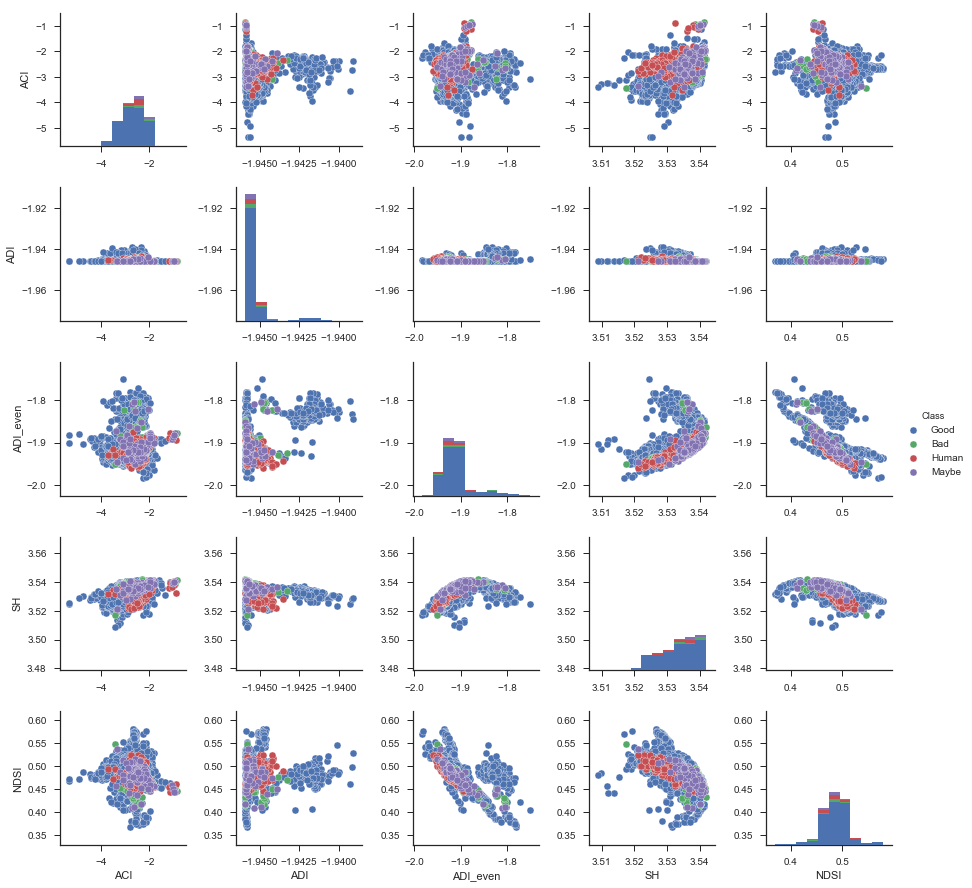

In [17]:
sns.pairplot(all_data_df, hue="Class")
plt.show()

In [18]:
gb_data_arr = [data_G, data_B]
gb_data_df = pd.concat(gb_data_arr)

print(gb_data_df.shape)
gb_data_df.head()

(3085, 6)


,ACI,ADI,ADI_even,SH,NDSI,Class
0,-2.140497,-1.945809,-1.925119,3.534064,0.501186,Good
1,-2.548170,-1.945811,-1.929581,3.531940,0.507842,Good
2,-3.035664,-1.945808,-1.912524,3.530267,0.478780,Good
3,-3.155140,-1.945805,-1.912569,3.529985,0.475351,Good
4,-2.402599,-1.945617,-1.927787,3.532227,0.495920,Good


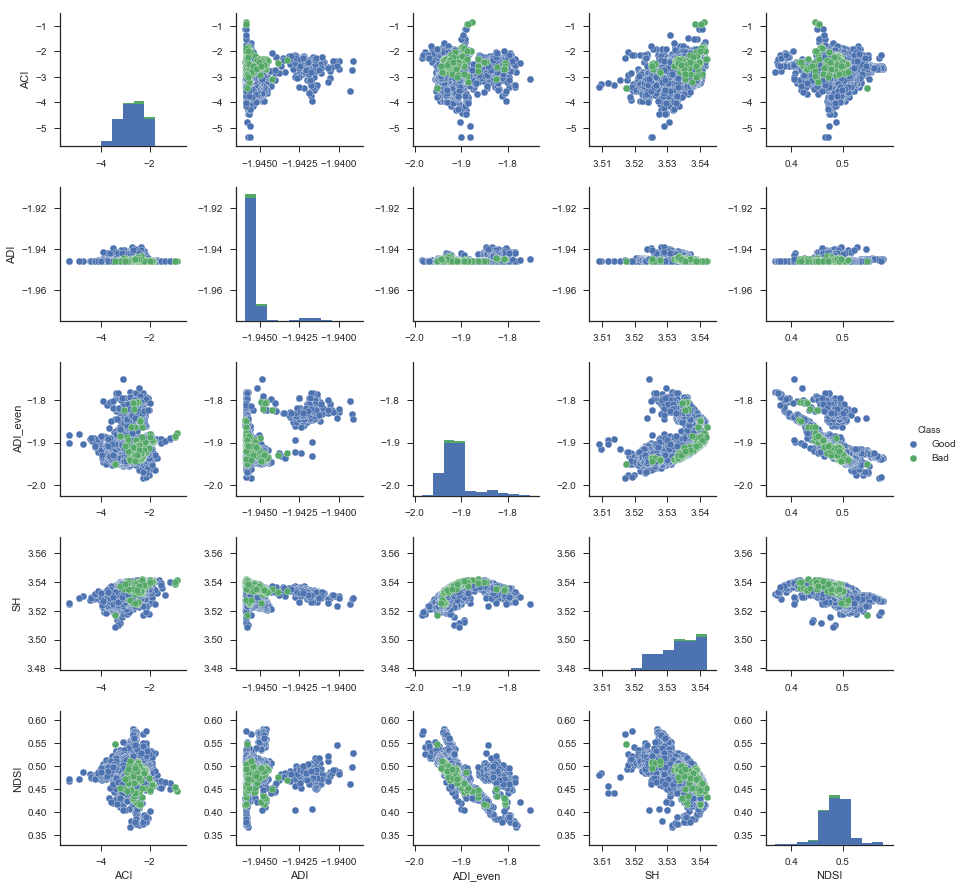

In [19]:
sns.pairplot(gb_data_df, hue="Class")
plt.show()